# Annolid on Detectron2 Tutorial 4 : Running inference

This is modified from the official colab tutorial of detectron2. Here, we will 

* Run inference using our previously trained model.

You can make a copy of this tutorial by "File -> Open in playground mode" and play with it yourself. __DO NOT__ request access to this tutorial.


In [1]:
# Is running in colab or in jupyter-notebook
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [2]:
# install dependencies: 
!pip install pyyaml==5.3
import torch, torchvision
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


torch:  1.10 ; cuda:  cu102


Defaulting to user installation because normal site-packages is not writeable


Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.10/index.html


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
# import some common libraries
import json
import os
import cv2
import random
import glob
import numpy as np
if IN_COLAB:
  from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


In [5]:
# is there a gpu
if torch.cuda.is_available():
    GPU = True
    print('gpu available')
else:
    GPU = False
    print('no gpu')

gpu available


# Let's test our newly trained model on a new video

## We download a video

In [6]:
!gdown --id 1aMCeFWng0JkRbw9LOytXXrv4I2qCiH0h

/home/jeremy/.local/lib/python3.8/site-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(


Downloading...
From: https://drive.google.com/uc?id=1aMCeFWng0JkRbw9LOytXXrv4I2qCiH0h
To: /home/jeremy/Documents/annolid/book/tutorials/novelctrl.mkv
  0%|                                                | 0.00/122M [00:00<?, ?B/s]

  6%|██▏                                    | 6.82M/122M [00:00<00:01, 67.9MB/s]

 21%|████████▍                               | 25.7M/122M [00:00<00:00, 123MB/s]

 31%|████████████▍                           | 37.7M/122M [00:00<00:00, 111MB/s]

 42%|████████████████▋                       | 50.9M/122M [00:00<00:00, 107MB/s]

 55%|██████████████████████▏                 | 67.6M/122M [00:00<00:00, 100MB/s]

 69%|███████████████████████████▋            | 84.4M/122M [00:00<00:00, 105MB/s]

 89%|████████████████████████████████████▋    | 109M/122M [00:00<00:00, 139MB/s]

100%|█████████████████████████████████████████| 122M/122M [00:00<00:00, 127MB/s]


### You can also download your own videos

In [7]:
#!wget https://hosting-website.com/your-video.mp4

In [8]:
if IN_COLAB:
    VIDEO_INPUT="/content/novelctrl.mkv"
    OUTPUT_DIR = "/content/eval_output"
else:
    VIDEO_INPUT="novelctrl.mkv"
    OUTPUT_DIR = "eval_output"

### If you use your own video / dataset you need to update the VIDEO_INPUT name

In [9]:
VIDEO_INPUT="YOUR_VIDEO_NAME"

In [10]:
if IN_COLAB:
    dataset = '/content/novelctrlk6_8_coco_dataset.zip'
else:
    dataset = 'novelctrlk6_8_coco_dataset.zip'

In [11]:
DATASET_NAME = DATASET_DIR = f"{dataset.replace('.zip','')}"

In [12]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import get_detection_dataset_dicts
from detectron2.data.datasets import  builtin_meta

In [13]:
register_coco_instances(f"{DATASET_NAME}_train", {}, f"{DATASET_DIR}/train/annotations.json", f"{DATASET_DIR}/train/")
register_coco_instances(f"{DATASET_NAME}_valid", {}, f"{DATASET_DIR}/valid/annotations.json", f"{DATASET_DIR}/valid/")

In [14]:
_dataset_metadata = MetadataCatalog.get(f"{DATASET_NAME}_train")
_dataset_metadata.thing_colors = [cc['color'] for cc in builtin_meta.COCO_CATEGORIES]

In [15]:
dataset_dicts = get_detection_dataset_dicts([f"{DATASET_NAME}_train"])

[05/03 10:11:14 d2.data.datasets.coco]: Loaded 118 images in COCO format from novelctrlk6_8_coco_dataset/train/annotations.json


[05/03 10:11:14 d2.data.build]: Removed 0 images with no usable annotations. 118 images left.


[05/03 10:11:14 d2.data.build]: Distribution of instances among all 7 categories:
|   category   | #instances   |  category  | #instances   |  category  | #instances   |
|:------------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| _background_ | 0            |    nose    | 118          |  left_ear  | 118          |
|  right_ear   | 117          | tail_base  | 119          |   mouse    | 118          |
|   centroid   | 1            |            |              |            |              |
|    total     | 591          |            |              |            |              |


In [16]:
NUM_CLASSES = len(_dataset_metadata.thing_classes)
print(f"{NUM_CLASSES} Number of classes in the dataset")

7 Number of classes in the dataset


In [17]:
import cv2

In [18]:
video = cv2.VideoCapture(VIDEO_INPUT)
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames_per_second = video.get(cv2.CAP_PROP_FPS)
num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
basename = os.path.basename(VIDEO_INPUT)

[ERROR:0] global /io/opencv/modules/videoio/src/cap.cpp (116) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.1.2) /io/opencv/modules/videoio/src/cap_images.cpp:253: error: (-5:Bad argument) CAP_IMAGES: can't find starting number (in the name of file): YOUR_VIDEO_NAME in function 'icvExtractPattern'




In [19]:
import os 
os.makedirs(OUTPUT_DIR,exist_ok=True)

In [20]:
def _frame_from_video(video):
  attempt = 0
  for i in range(num_frames):
      success, frame = video.read()
      if success:
          yield frame
      else:
          attempt += 1
          if attempt >= 2000:
              break
          else:
              video.set(cv2.CAP_PROP_POS_FRAMES, i+1)
              print('Cannot read this frame:', i)
              continue

In [21]:
import pandas as pd
import pycocotools.mask as mask_util

In [22]:
class_names = _dataset_metadata.thing_classes
print(class_names)

['_background_', 'nose', 'left_ear', 'right_ear', 'tail_base', 'mouse', 'centroid']


In [23]:
from detectron2.engine import DefaultTrainer

In [24]:
cfg = get_cfg()

In [25]:
if GPU:
    pass
else:
    cfg.MODEL.DEVICE='cpu'

In [26]:
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (f"{DATASET_NAME}_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2 #@param
cfg.DATALOADER.SAMPLER_TRAIN = "RepeatFactorTrainingSampler"
cfg.DATALOADER.REPEAT_THRESHOLD = 0.3
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH =  4 #@param
cfg.SOLVER.BASE_LR = 0.0025 #@param # pick a good LR
cfg.SOLVER.MAX_ITER = 3000 #@param    # 300 iterations seems good enough for 100 frames dataset; you will need to train longer for a practical dataset
cfg.SOLVER.CHECKPOINT_PERIOD = 1000 #@param 
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 32 #@param   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES  #  (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [27]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. 
# We simply update the weights with the newly trained ones to perform inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
# set a custom testing threshold
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.15   #@param {type: "slider", min:0.0, max:1.0, step: 0.01}
predictor = DefaultPredictor(cfg)

In [28]:
from detectron2.utils.visualizer import ColorMode

/home/jeremy/anaconda3/envs/annolid-env/lib/python3.7/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/jeremy/anaconda3/envs/annolid-env/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


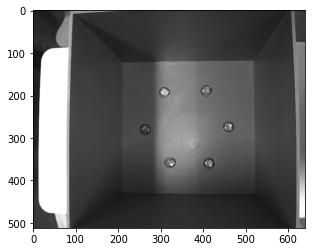

Processing frame number 1
Processing frame number 2
Processing frame number 3
Processing frame number 4
Processing frame number 5
Processing frame number 6
Processing frame number 7
Processing frame number 8
Processing frame number 9
Processing frame number 10
Processing frame number 11
Processing frame number 12
Processing frame number 13
Processing frame number 14
Processing frame number 15
Processing frame number 16
Processing frame number 17
Processing frame number 18
Processing frame number 19
Processing frame number 20
Processing frame number 21
Processing frame number 22
Processing frame number 23
Processing frame number 24
Processing frame number 25
Processing frame number 26
Processing frame number 27
Processing frame number 28
Processing frame number 29
Processing frame number 30
Processing frame number 31
Processing frame number 32
Processing frame number 33
Processing frame number 34
Processing frame number 35
Processing frame number 36
Processing frame number 37
Processing

Processing frame number 300
Processing frame number 301
Processing frame number 302
Processing frame number 303
Processing frame number 304
Processing frame number 305
Processing frame number 306
Processing frame number 307
Processing frame number 308
Processing frame number 309
Processing frame number 310
Processing frame number 311
Processing frame number 312
Processing frame number 313
Processing frame number 314
Processing frame number 315
Processing frame number 316
Processing frame number 317
Processing frame number 318
Processing frame number 319
Processing frame number 320
Processing frame number 321
Processing frame number 322
Processing frame number 323
Processing frame number 324
Processing frame number 325
Processing frame number 326
Processing frame number 327
Processing frame number 328
Processing frame number 329
Processing frame number 330
Processing frame number 331
Processing frame number 332
Processing frame number 333
Processing frame number 334
Processing frame num

Processing frame number 595
Processing frame number 596
Processing frame number 597
Processing frame number 598
Processing frame number 599
Processing frame number 600
Processing frame number 601
Processing frame number 602
Processing frame number 603
Processing frame number 604
Processing frame number 605
Processing frame number 606
Processing frame number 607
Processing frame number 608
Processing frame number 609
Processing frame number 610
Processing frame number 611
Processing frame number 612
Processing frame number 613
Processing frame number 614
Processing frame number 615
Processing frame number 616
Processing frame number 617
Processing frame number 618
Processing frame number 619
Processing frame number 620
Processing frame number 621
Processing frame number 622
Processing frame number 623
Processing frame number 624
Processing frame number 625
Processing frame number 626
Processing frame number 627
Processing frame number 628
Processing frame number 629
Processing frame num

Processing frame number 889
Processing frame number 890
Processing frame number 891
Processing frame number 892
Processing frame number 893
Processing frame number 894
Processing frame number 895
Processing frame number 896
Processing frame number 897
Processing frame number 898
Processing frame number 899
Processing frame number 900
Processing frame number 901
Processing frame number 902
Processing frame number 903
Processing frame number 904
Processing frame number 905
Processing frame number 906
Processing frame number 907
Processing frame number 908
Processing frame number 909
Processing frame number 910
Processing frame number 911
Processing frame number 912
Processing frame number 913
Processing frame number 914
Processing frame number 915
Processing frame number 916
Processing frame number 917
Processing frame number 918
Processing frame number 919
Processing frame number 920
Processing frame number 921
Processing frame number 922
Processing frame number 923
Processing frame num

Processing frame number 1108
Processing frame number 1109
Processing frame number 1110
Processing frame number 1111
Processing frame number 1112
Processing frame number 1113
Processing frame number 1114
Processing frame number 1115
Processing frame number 1116
Processing frame number 1117
Processing frame number 1118
Processing frame number 1119
Processing frame number 1120
Processing frame number 1121
Processing frame number 1122
Processing frame number 1123
Processing frame number 1124
Processing frame number 1125
Processing frame number 1126
Processing frame number 1127
Processing frame number 1128
Processing frame number 1129
Processing frame number 1130
Processing frame number 1131
Processing frame number 1132
Processing frame number 1133
Processing frame number 1134
Processing frame number 1135
Processing frame number 1136
Processing frame number 1137
Processing frame number 1138
Processing frame number 1139
Processing frame number 1140
Processing frame number 1141
Processing fra

Processing frame number 1392
Processing frame number 1393
Processing frame number 1394
Processing frame number 1395
Processing frame number 1396
Processing frame number 1397
Processing frame number 1398
Processing frame number 1399
Processing frame number 1400
Processing frame number 1401
Processing frame number 1402
Processing frame number 1403
Processing frame number 1404
Processing frame number 1405
Processing frame number 1406
Processing frame number 1407
Processing frame number 1408
Processing frame number 1409
Processing frame number 1410
Processing frame number 1411
Processing frame number 1412
Processing frame number 1413
Processing frame number 1414
Processing frame number 1415
Processing frame number 1416
Processing frame number 1417
Processing frame number 1418
Processing frame number 1419
Processing frame number 1420
Processing frame number 1421
Processing frame number 1422
Processing frame number 1423
Processing frame number 1424
Processing frame number 1425
Processing fra

Processing frame number 1677
Processing frame number 1678
Processing frame number 1679
Processing frame number 1680
Processing frame number 1681
Processing frame number 1682
Processing frame number 1683
Processing frame number 1684
Processing frame number 1685
Processing frame number 1686
Processing frame number 1687
Processing frame number 1688
Processing frame number 1689
Processing frame number 1690
Processing frame number 1691
Processing frame number 1692
Processing frame number 1693
Processing frame number 1694
Processing frame number 1695
Processing frame number 1696
Processing frame number 1697
Processing frame number 1698
Processing frame number 1699
Processing frame number 1700
Processing frame number 1701
Processing frame number 1702
Processing frame number 1703
Processing frame number 1704
Processing frame number 1705
Processing frame number 1706
Processing frame number 1707
Processing frame number 1708
Processing frame number 1709
Processing frame number 1710
Processing fra

Processing frame number 1961
Processing frame number 1962
Processing frame number 1963
Processing frame number 1964
Processing frame number 1965
Processing frame number 1966
Processing frame number 1967
Processing frame number 1968
Processing frame number 1969
Processing frame number 1970
Processing frame number 1971
Processing frame number 1972
Processing frame number 1973
Processing frame number 1974
Processing frame number 1975
Processing frame number 1976
Processing frame number 1977
Processing frame number 1978
Processing frame number 1979
Processing frame number 1980
Processing frame number 1981
Processing frame number 1982
Processing frame number 1983
Processing frame number 1984
Processing frame number 1985
Processing frame number 1986
Processing frame number 1987
Processing frame number 1988
Processing frame number 1989
Processing frame number 1990
Processing frame number 1991
Processing frame number 1992
Processing frame number 1993
Processing frame number 1994
Processing fra

Processing frame number 2169
Processing frame number 2170
Processing frame number 2171
Processing frame number 2172
Processing frame number 2173
Processing frame number 2174
Processing frame number 2175
Processing frame number 2176
Processing frame number 2177
Processing frame number 2178
Processing frame number 2179
Processing frame number 2180
Processing frame number 2181
Processing frame number 2182
Processing frame number 2183
Processing frame number 2184
Processing frame number 2185
Processing frame number 2186
Processing frame number 2187
Processing frame number 2188
Processing frame number 2189
Processing frame number 2190
Processing frame number 2191
Processing frame number 2192
Processing frame number 2193
Processing frame number 2194
Processing frame number 2195
Processing frame number 2196
Processing frame number 2197
Processing frame number 2198
Processing frame number 2199
Processing frame number 2200
Processing frame number 2201
Processing frame number 2202
Processing fra

Processing frame number 2454
Processing frame number 2455
Processing frame number 2456
Processing frame number 2457
Processing frame number 2458
Processing frame number 2459
Processing frame number 2460
Processing frame number 2461
Processing frame number 2462
Processing frame number 2463
Processing frame number 2464
Processing frame number 2465
Processing frame number 2466
Processing frame number 2467
Processing frame number 2468
Processing frame number 2469
Processing frame number 2470
Processing frame number 2471
Processing frame number 2472
Processing frame number 2473
Processing frame number 2474
Processing frame number 2475
Processing frame number 2476
Processing frame number 2477
Processing frame number 2478
Processing frame number 2479
Processing frame number 2480
Processing frame number 2481
Processing frame number 2482
Processing frame number 2483
Processing frame number 2484
Processing frame number 2485
Processing frame number 2486
Processing frame number 2487
Processing fra

Processing frame number 2737
Processing frame number 2738
Processing frame number 2739
Processing frame number 2740
Processing frame number 2741
Processing frame number 2742
Processing frame number 2743
Processing frame number 2744
Processing frame number 2745
Processing frame number 2746
Processing frame number 2747
Processing frame number 2748
Processing frame number 2749
Processing frame number 2750
Processing frame number 2751
Processing frame number 2752
Processing frame number 2753
Processing frame number 2754
Processing frame number 2755
Processing frame number 2756
Processing frame number 2757
Processing frame number 2758
Processing frame number 2759
Processing frame number 2760
Processing frame number 2761
Processing frame number 2762
Processing frame number 2763
Processing frame number 2764
Processing frame number 2765
Processing frame number 2766
Processing frame number 2767
Processing frame number 2768
Processing frame number 2769
Processing frame number 2770
Processing fra

Processing frame number 3004
Processing frame number 3005
Processing frame number 3006
Processing frame number 3007
Processing frame number 3008
Processing frame number 3009
Processing frame number 3010
Processing frame number 3011
Processing frame number 3012
Processing frame number 3013
Processing frame number 3014
Processing frame number 3015
Processing frame number 3016
Processing frame number 3017
Processing frame number 3018
Processing frame number 3019
Processing frame number 3020
Processing frame number 3021
Processing frame number 3022
Processing frame number 3023
Processing frame number 3024
Processing frame number 3025
Processing frame number 3026
Processing frame number 3027
Processing frame number 3028
Processing frame number 3029
Processing frame number 3030
Processing frame number 3031
Processing frame number 3032
Processing frame number 3033
Processing frame number 3034
Processing frame number 3035
Processing frame number 3036
Processing frame number 3037
Processing fra

Processing frame number 3289
Processing frame number 3290
Processing frame number 3291
Processing frame number 3292
Processing frame number 3293
Processing frame number 3294
Processing frame number 3295
Processing frame number 3296
Processing frame number 3297
Processing frame number 3298
Processing frame number 3299
Processing frame number 3300
Processing frame number 3301
Processing frame number 3302
Processing frame number 3303
Processing frame number 3304
Processing frame number 3305
Processing frame number 3306
Processing frame number 3307
Processing frame number 3308
Processing frame number 3309
Processing frame number 3310
Processing frame number 3311
Processing frame number 3312
Processing frame number 3313
Processing frame number 3314
Processing frame number 3315
Processing frame number 3316
Processing frame number 3317
Processing frame number 3318
Processing frame number 3319
Processing frame number 3320
Processing frame number 3321
Processing frame number 3322
Processing fra

Processing frame number 3573
Processing frame number 3574
Processing frame number 3575
Processing frame number 3576
Processing frame number 3577
Processing frame number 3578
Processing frame number 3579
Processing frame number 3580
Processing frame number 3581
Processing frame number 3582
Processing frame number 3583
Processing frame number 3584
Processing frame number 3585
Processing frame number 3586
Processing frame number 3587
Processing frame number 3588
Processing frame number 3589
Processing frame number 3590
Processing frame number 3591
Processing frame number 3592
Processing frame number 3593
Processing frame number 3594
Processing frame number 3595
Processing frame number 3596
Processing frame number 3597
Processing frame number 3598
Processing frame number 3599
Processing frame number 3600
Processing frame number 3601
Processing frame number 3602
Processing frame number 3603
Processing frame number 3604
Processing frame number 3605
Processing frame number 3606
Processing fra

Processing frame number 3856
Processing frame number 3857
Processing frame number 3858
Processing frame number 3859
Processing frame number 3860
Processing frame number 3861
Processing frame number 3862
Processing frame number 3863
Processing frame number 3864
Processing frame number 3865
Processing frame number 3866
Processing frame number 3867
Processing frame number 3868
Processing frame number 3869
Processing frame number 3870
Processing frame number 3871
Processing frame number 3872
Processing frame number 3873
Processing frame number 3874
Processing frame number 3875
Processing frame number 3876
Processing frame number 3877
Processing frame number 3878
Processing frame number 3879
Processing frame number 3880
Processing frame number 3881
Processing frame number 3882
Processing frame number 3883
Processing frame number 3884
Processing frame number 3885
Processing frame number 3886
Processing frame number 3887
Processing frame number 3888
Processing frame number 3889
Processing fra

Processing frame number 4045
Processing frame number 4046
Processing frame number 4047
Processing frame number 4048
Processing frame number 4049
Processing frame number 4050
Processing frame number 4051
Processing frame number 4052
Processing frame number 4053
Processing frame number 4054
Processing frame number 4055
Processing frame number 4056
Processing frame number 4057
Processing frame number 4058
Processing frame number 4059
Processing frame number 4060
Processing frame number 4061
Processing frame number 4062
Processing frame number 4063
Processing frame number 4064
Processing frame number 4065
Processing frame number 4066
Processing frame number 4067
Processing frame number 4068
Processing frame number 4069
Processing frame number 4070
Processing frame number 4071
Processing frame number 4072
Processing frame number 4073
Processing frame number 4074
Processing frame number 4075
Processing frame number 4076
Processing frame number 4077
Processing frame number 4078
Processing fra

Processing frame number 4330
Processing frame number 4331
Processing frame number 4332
Processing frame number 4333
Processing frame number 4334
Processing frame number 4335
Processing frame number 4336
Processing frame number 4337
Processing frame number 4338
Processing frame number 4339
Processing frame number 4340
Processing frame number 4341
Processing frame number 4342
Processing frame number 4343
Processing frame number 4344
Processing frame number 4345
Processing frame number 4346
Processing frame number 4347
Processing frame number 4348
Processing frame number 4349
Processing frame number 4350
Processing frame number 4351
Processing frame number 4352
Processing frame number 4353
Processing frame number 4354
Processing frame number 4355
Processing frame number 4356
Processing frame number 4357
Processing frame number 4358
Processing frame number 4359
Processing frame number 4360
Processing frame number 4361
Processing frame number 4362
Processing frame number 4363
Processing fra

Processing frame number 4615
Processing frame number 4616
Processing frame number 4617
Processing frame number 4618
Processing frame number 4619
Processing frame number 4620
Processing frame number 4621
Processing frame number 4622
Processing frame number 4623
Processing frame number 4624
Processing frame number 4625
Processing frame number 4626
Processing frame number 4627
Processing frame number 4628
Processing frame number 4629
Processing frame number 4630
Processing frame number 4631
Processing frame number 4632
Processing frame number 4633
Processing frame number 4634
Processing frame number 4635
Processing frame number 4636
Processing frame number 4637
Processing frame number 4638
Processing frame number 4639
Processing frame number 4640
Processing frame number 4641
Processing frame number 4642
Processing frame number 4643
Processing frame number 4644
Processing frame number 4645
Processing frame number 4646
Processing frame number 4647
Processing frame number 4648
Processing fra

Processing frame number 4900
Processing frame number 4901
Processing frame number 4902
Processing frame number 4903
Processing frame number 4904
Processing frame number 4905
Processing frame number 4906
Processing frame number 4907
Processing frame number 4908
Processing frame number 4909
Processing frame number 4910
Processing frame number 4911
Processing frame number 4912
Processing frame number 4913
Processing frame number 4914
Processing frame number 4915
Processing frame number 4916
Processing frame number 4917
Processing frame number 4918
Processing frame number 4919
Processing frame number 4920
Processing frame number 4921
Processing frame number 4922
Processing frame number 4923
Processing frame number 4924
Processing frame number 4925
Processing frame number 4926
Processing frame number 4927
Processing frame number 4928
Processing frame number 4929
Processing frame number 4930
Processing frame number 4931
Processing frame number 4932
Processing frame number 4933
Processing fra

Processing frame number 5091
Processing frame number 5092
Processing frame number 5093
Processing frame number 5094
Processing frame number 5095
Processing frame number 5096
Processing frame number 5097
Processing frame number 5098
Processing frame number 5099
Processing frame number 5100
Processing frame number 5101
Processing frame number 5102
Processing frame number 5103
Processing frame number 5104
Processing frame number 5105
Processing frame number 5106
Processing frame number 5107
Processing frame number 5108
Processing frame number 5109
Processing frame number 5110
Processing frame number 5111
Processing frame number 5112
Processing frame number 5113
Processing frame number 5114
Processing frame number 5115
Processing frame number 5116
Processing frame number 5117
Processing frame number 5118
Processing frame number 5119
Processing frame number 5120
Processing frame number 5121
Processing frame number 5122
Processing frame number 5123
Processing frame number 5124
Processing fra

Processing frame number 5376
Processing frame number 5377
Processing frame number 5378
Processing frame number 5379
Processing frame number 5380
Processing frame number 5381
Processing frame number 5382
Processing frame number 5383
Processing frame number 5384
Processing frame number 5385
Processing frame number 5386
Processing frame number 5387
Processing frame number 5388
Processing frame number 5389
Processing frame number 5390
Processing frame number 5391
Processing frame number 5392
Processing frame number 5393
Processing frame number 5394
Processing frame number 5395
Processing frame number 5396
Processing frame number 5397
Processing frame number 5398
Processing frame number 5399
Processing frame number 5400
Processing frame number 5401
Processing frame number 5402
Processing frame number 5403
Processing frame number 5404
Processing frame number 5405
Processing frame number 5406
Processing frame number 5407
Processing frame number 5408
Processing frame number 5409
Processing fra

Processing frame number 5661
Processing frame number 5662
Processing frame number 5663
Processing frame number 5664
Processing frame number 5665
Processing frame number 5666
Processing frame number 5667
Processing frame number 5668
Processing frame number 5669
Processing frame number 5670
Processing frame number 5671
Processing frame number 5672
Processing frame number 5673
Processing frame number 5674
Processing frame number 5675
Processing frame number 5676
Processing frame number 5677
Processing frame number 5678
Processing frame number 5679
Processing frame number 5680
Processing frame number 5681
Processing frame number 5682
Processing frame number 5683
Processing frame number 5684
Processing frame number 5685
Processing frame number 5686
Processing frame number 5687
Processing frame number 5688
Processing frame number 5689
Processing frame number 5690
Processing frame number 5691
Processing frame number 5692
Processing frame number 5693
Processing frame number 5694
Processing fra

Processing frame number 5946
Processing frame number 5947
Processing frame number 5948
Processing frame number 5949
Processing frame number 5950
Processing frame number 5951
Processing frame number 5952
Processing frame number 5953
Processing frame number 5954
Processing frame number 5955
Processing frame number 5956
Processing frame number 5957
Processing frame number 5958
Processing frame number 5959
Processing frame number 5960
Processing frame number 5961
Processing frame number 5962
Processing frame number 5963
Processing frame number 5964
Processing frame number 5965
Processing frame number 5966
Processing frame number 5967
Processing frame number 5968
Processing frame number 5969
Processing frame number 5970
Processing frame number 5971
Processing frame number 5972
Processing frame number 5973
Processing frame number 5974
Processing frame number 5975
Processing frame number 5976
Processing frame number 5977
Processing frame number 5978
Processing frame number 5979
Processing fra

Processing frame number 6147
Processing frame number 6148
Processing frame number 6149
Processing frame number 6150
Processing frame number 6151
Processing frame number 6152
Processing frame number 6153
Processing frame number 6154
Processing frame number 6155
Processing frame number 6156
Processing frame number 6157
Processing frame number 6158
Processing frame number 6159
Processing frame number 6160
Processing frame number 6161
Processing frame number 6162
Processing frame number 6163
Processing frame number 6164
Processing frame number 6165
Processing frame number 6166
Processing frame number 6167
Processing frame number 6168
Processing frame number 6169
Processing frame number 6170
Processing frame number 6171
Processing frame number 6172
Processing frame number 6173
Processing frame number 6174
Processing frame number 6175
Processing frame number 6176
Processing frame number 6177
Processing frame number 6178
Processing frame number 6179
Processing frame number 6180
Processing fra

Processing frame number 6432
Processing frame number 6433
Processing frame number 6434
Processing frame number 6435
Processing frame number 6436
Processing frame number 6437
Processing frame number 6438
Processing frame number 6439
Processing frame number 6440
Processing frame number 6441
Processing frame number 6442
Processing frame number 6443
Processing frame number 6444
Processing frame number 6445
Processing frame number 6446
Processing frame number 6447
Processing frame number 6448
Processing frame number 6449
Processing frame number 6450
Processing frame number 6451
Processing frame number 6452
Processing frame number 6453
Processing frame number 6454
Processing frame number 6455
Processing frame number 6456
Processing frame number 6457
Processing frame number 6458
Processing frame number 6459
Processing frame number 6460
Processing frame number 6461
Processing frame number 6462
Processing frame number 6463
Processing frame number 6464
Processing frame number 6465
Processing fra

Processing frame number 6717
Processing frame number 6718
Processing frame number 6719
Processing frame number 6720
Processing frame number 6721
Processing frame number 6722
Processing frame number 6723
Processing frame number 6724
Processing frame number 6725
Processing frame number 6726
Processing frame number 6727
Processing frame number 6728
Processing frame number 6729
Processing frame number 6730
Processing frame number 6731
Processing frame number 6732
Processing frame number 6733
Processing frame number 6734
Processing frame number 6735
Processing frame number 6736
Processing frame number 6737
Processing frame number 6738
Processing frame number 6739
Processing frame number 6740
Processing frame number 6741
Processing frame number 6742
Processing frame number 6743
Processing frame number 6744
Processing frame number 6745
Processing frame number 6746
Processing frame number 6747
Processing frame number 6748
Processing frame number 6749
Processing frame number 6750
Processing fra

Processing frame number 6999
Processing frame number 7000
Frame number 7000: {'frame_number': 7000, 'x1': 770.0821533203125, 'y1': 728.421630859375, 'x2': 920.4229736328125, 'y2': 874.448974609375, 'instance_name': 'mouse', 'class_score': 0.9988065958023071, 'segmentation': {'size': [1024, 1280], 'counts': 'ShSh0d0Xo0:H5H9E>E9I4L3N3L4M4L2N2N102M2N2N2O0O2O1O1O1N1010O0001O0010O10000O100O2N2O1N2O0O2O1O0O2O0O2N2O1N2O0O2O1O1O0O2O0O101N2O1O0O2O1RO\\RO\\Ofm0;cROC_m09eROF\\m07fROH]m01hRONen001O10O01O00100O1O0001O01O0001O01O00001O0010O000001O0000000010O000000000000001O0O100000000O01000O1O1O1O010O10O01O0001O00001O01OO2O001N10100O1N3N1N3MjU^;'}}
Frame number 7000: {'frame_number': 7000, 'x1': 780.972900390625, 'y1': 734.1707153320312, 'x2': 802.4872436523438, 'y2': 754.1156616210938, 'instance_name': 'nose', 'class_score': 0.990962564945221, 'segmentation': {'size': [1024, 1280], 'counts': 'Xg`h04io04M2N200O2O0O1000O10000O1O2N1N4LPYn>'}}
Frame number 7000: {'frame_number': 7000, 'x1': 812.3989868

Processing frame number 7191
Processing frame number 7192
Processing frame number 7193
Processing frame number 7194
Processing frame number 7195
Processing frame number 7196
Processing frame number 7197
Processing frame number 7198
Processing frame number 7199
Processing frame number 7200
Processing frame number 7201
Processing frame number 7202
Processing frame number 7203
Processing frame number 7204
Processing frame number 7205
Processing frame number 7206
Processing frame number 7207
Processing frame number 7208
Processing frame number 7209
Processing frame number 7210
Processing frame number 7211
Processing frame number 7212
Processing frame number 7213
Processing frame number 7214
Processing frame number 7215
Processing frame number 7216
Processing frame number 7217
Processing frame number 7218
Processing frame number 7219
Processing frame number 7220
Processing frame number 7221
Processing frame number 7222
Processing frame number 7223
Processing frame number 7224
Processing fra

Processing frame number 7476
Processing frame number 7477
Processing frame number 7478
Processing frame number 7479
Processing frame number 7480
Processing frame number 7481
Processing frame number 7482
Processing frame number 7483
Processing frame number 7484
Processing frame number 7485
Processing frame number 7486
Processing frame number 7487
Processing frame number 7488
Processing frame number 7489
Processing frame number 7490
Processing frame number 7491
Processing frame number 7492
Processing frame number 7493
Processing frame number 7494
Processing frame number 7495
Processing frame number 7496
Processing frame number 7497
Processing frame number 7498
Processing frame number 7499
Processing frame number 7500
Processing frame number 7501
Processing frame number 7502
Processing frame number 7503
Processing frame number 7504
Processing frame number 7505
Processing frame number 7506
Processing frame number 7507
Processing frame number 7508
Processing frame number 7509
Processing fra

Processing frame number 7761
Processing frame number 7762
Processing frame number 7763
Processing frame number 7764
Processing frame number 7765
Processing frame number 7766
Processing frame number 7767
Processing frame number 7768
Processing frame number 7769
Processing frame number 7770
Processing frame number 7771
Processing frame number 7772
Processing frame number 7773
Processing frame number 7774
Processing frame number 7775
Processing frame number 7776
Processing frame number 7777
Processing frame number 7778
Processing frame number 7779
Processing frame number 7780
Processing frame number 7781
Processing frame number 7782
Processing frame number 7783
Processing frame number 7784
Processing frame number 7785
Processing frame number 7786
Processing frame number 7787
Processing frame number 7788
Processing frame number 7789
Processing frame number 7790
Processing frame number 7791
Processing frame number 7792
Processing frame number 7793
Processing frame number 7794
Processing fra

Processing frame number 8004
Processing frame number 8005
Processing frame number 8006
Processing frame number 8007
Processing frame number 8008
Processing frame number 8009
Processing frame number 8010
Processing frame number 8011
Processing frame number 8012
Processing frame number 8013
Processing frame number 8014
Processing frame number 8015
Processing frame number 8016
Processing frame number 8017
Processing frame number 8018
Processing frame number 8019
Processing frame number 8020
Processing frame number 8021
Processing frame number 8022
Processing frame number 8023
Processing frame number 8024
Processing frame number 8025
Processing frame number 8026
Processing frame number 8027
Processing frame number 8028
Processing frame number 8029
Processing frame number 8030
Processing frame number 8031
Processing frame number 8032
Processing frame number 8033
Processing frame number 8034
Processing frame number 8035
Processing frame number 8036
Processing frame number 8037
Processing fra

Processing frame number 8289
Processing frame number 8290
Processing frame number 8291
Processing frame number 8292
Processing frame number 8293
Processing frame number 8294
Processing frame number 8295
Processing frame number 8296
Processing frame number 8297
Processing frame number 8298
Processing frame number 8299
Processing frame number 8300
Processing frame number 8301
Processing frame number 8302
Processing frame number 8303
Processing frame number 8304
Processing frame number 8305
Processing frame number 8306
Processing frame number 8307
Processing frame number 8308
Processing frame number 8309
Processing frame number 8310
Processing frame number 8311
Processing frame number 8312
Processing frame number 8313
Processing frame number 8314
Processing frame number 8315
Processing frame number 8316
Processing frame number 8317
Processing frame number 8318
Processing frame number 8319
Processing frame number 8320
Processing frame number 8321
Processing frame number 8322
Processing fra

Processing frame number 8574
Processing frame number 8575
Processing frame number 8576
Processing frame number 8577
Processing frame number 8578
Processing frame number 8579
Processing frame number 8580
Processing frame number 8581
Processing frame number 8582
Processing frame number 8583
Processing frame number 8584
Processing frame number 8585
Processing frame number 8586
Processing frame number 8587
Processing frame number 8588
Processing frame number 8589
Processing frame number 8590
Processing frame number 8591
Processing frame number 8592
Processing frame number 8593
Processing frame number 8594
Processing frame number 8595
Processing frame number 8596
Processing frame number 8597
Processing frame number 8598
Processing frame number 8599
Processing frame number 8600
Processing frame number 8601
Processing frame number 8602
Processing frame number 8603
Processing frame number 8604
Processing frame number 8605
Processing frame number 8606
Processing frame number 8607
Processing fra

Processing frame number 8858
Processing frame number 8859
Processing frame number 8860
Processing frame number 8861
Processing frame number 8862
Processing frame number 8863
Processing frame number 8864
Processing frame number 8865
Processing frame number 8866
Processing frame number 8867
Processing frame number 8868
Processing frame number 8869
Processing frame number 8870
Processing frame number 8871
Processing frame number 8872
Processing frame number 8873
Processing frame number 8874
Processing frame number 8875
Processing frame number 8876
Processing frame number 8877
Processing frame number 8878
Processing frame number 8879
Processing frame number 8880
Processing frame number 8881
Processing frame number 8882
Processing frame number 8883
Processing frame number 8884
Processing frame number 8885
Processing frame number 8886
Processing frame number 8887
Processing frame number 8888
Processing frame number 8889
Processing frame number 8890
Processing frame number 8891
Processing fra

In [ ]:
frame_number = 0
tracking_results = []
VIS = True
for frame in _frame_from_video(video): 
    im = frame
    outputs = predictor(im)
    out_dict = {}  
    instances = outputs["instances"].to("cpu")
    num_instance = len(instances)
    if num_instance == 0:
        out_dict['frame_number'] = frame_number
        out_dict['x1'] = None
        out_dict['y1'] = None
        out_dict['x2'] = None
        out_dict['y2'] = None
        out_dict['instance_name'] = None
        out_dict['class_score'] = None
        out_dict['segmentation'] = None
        tracking_results.append(out_dict)
        out_dict = {}
    else:
        boxes = instances.pred_boxes.tensor.numpy()
        boxes = boxes.tolist()
        scores = instances.scores.tolist()
        classes = instances.pred_classes.tolist()

        has_mask = instances.has("pred_masks")

        if has_mask:
            rles =[
                   mask_util.encode(np.array(mask[:,:,None], order="F", dtype="uint8"))[0]
                   for mask in instances.pred_masks
            ]
            for rle in rles:
              rle["counts"] = rle["counts"].decode("utf-8")

        assert len(rles) == len(boxes)
        for k in range(num_instance):
            box = boxes[k]
            out_dict['frame_number'] = frame_number
            out_dict['x1'] = box[0]
            out_dict['y1'] = box[1]
            out_dict['x2'] = box[2]
            out_dict['y2'] = box[3]
            out_dict['instance_name'] = class_names[classes[k]]
            out_dict['class_score'] = scores[k]
            out_dict['segmentation'] = rles[k]
            if frame_number % 1000 == 0:
              print(f"Frame number {frame_number}: {out_dict}")
            tracking_results.append(out_dict)
            out_dict = {}
        
    # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    if VIS:
        v = Visualizer(im[:, :, ::-1],
                    metadata=_dataset_metadata, 
                    scale=0.5, 
                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
         )
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        out_image = out.get_image()[:, :, ::-1]
        if frame_number % 1000 == 0:
            if IN_COLAB:
                cv2_imshow(out_image)
            else:
                plt.imshow(out_image)
                plt.show()
            #Trun off the visulization to save time after the first frame
            VIS = False
    frame_number += 1
    print(f"Processing frame number {frame_number}")

video.release()

## All the tracking results will be saved to this Pandas dataframe. 



In [ ]:
df = pd.DataFrame(tracking_results).dropna()

In [ ]:
df.head()

## Calculate the bbox center point x, y locations

In [ ]:
cx = (df.x1 + df.x2)/2
cy = (df.y1 + df.y2)/2
df['cx'] = cx
df['cy'] = cy

df.head()

## Only save the top 1 prediction for each frame for each class
Note: You can change the number to save top n predictions for each frame and an instance name. head(2), head(5), or head(n)
To save all the predictions, please use `df.to_csv('my_tracking_results.csv')`.

In [ ]:
df_top = df.groupby(['frame_number','instance_name'],sort=False).head(1)

In [ ]:
df_top.head()

## Visualize the center points with plotly scatter plot

In [ ]:
df_vis = df_top[df_top.instance_name != 'Text'][['frame_number','cx','cy','instance_name']]

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

fig = px.scatter(df_vis, 
                 x="cx",
                 y="cy", 
                 color="instance_name",
                 hover_data=['frame_number','cx','cy'])
fig.show()

In [ ]:
from pathlib import  Path
tracking_results_csv = f"{Path(dataset).stem}_{Path(VIDEO_INPUT).stem}_{cfg.SOLVER.MAX_ITER}_iters_mask_rcnn_tracking_results_with_segmenation.csv"
df_top.to_csv(tracking_results_csv)

## Download the tracking result CSV file to your local computer

In [ ]:
if IN_COLAB:
    from google.colab import files
    files.download(tracking_results_csv)
else:
    from IPython.display import FileLink
    FileLink(tracking_results_csv)